# Advanced Coding Group Project - 2024/25 
#### Students: Michele Turco, Mattia Cervelli, Lorenzo Laterza 

## 0) Import Libraries and the Dataset

Setup your python environment and download the credit-score data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
credit_card_df = pd.read_csv('train_biased.csv')

## 1) Understanding the dataset



#### 1.1) General overview of the dataset

Using the function .head(), we can extract from the dataset the first x rows (x=5 by default, but we can change this number). They are not useful for analytic purposes, but still enable us to visualize the dataset.

In [3]:
credit_card_df.head

<bound method NDFrame.head of             ID Customer_ID     Month           Name          City  \
0          NaN   CUS_0xd40       NaN  Aaron Maashoh        Lonton   
1       0x1603   CUS_0xd40  February  Aaron Maashoh        Lonton   
2       0x1604   CUS_0xd40       NaN            NaN        Lonton   
3       0x1605   CUS_0xd40     April  Aaron Maashoh        Lonton   
4          NaN   CUS_0xd40       May  Aaron Maashoh        Lonton   
...        ...         ...       ...            ...           ...   
99995  0x25fe9  CUS_0x942c     April          Nicks      BadShire   
99996  0x25fea  CUS_0x942c       May          Nicks      BadShire   
99997  0x25feb         NaN      June          Nicks      BadShire   
99998  0x25fec  CUS_0x942c      July          Nicks  Standhampton   
99999  0x25fed  CUS_0x942c    August          Nicks      BadShire   

              Street    Age          SSN Occupation Annual_Income  ...  \
0      Oxford Street    NaN  821-00-0265    Manager      19114.12  

#### 1.2) Showing the dataset shape

In [4]:
# Identify Number of Columns and Rows
n_rows = len(credit_card_df)
n_columns = len(credit_card_df.columns)
print(f"The dataset contains {n_columns} columns")
print(f"The dataset contains {n_rows} rows")

The dataset contains 27 columns
The dataset contains 100000 rows


#### 1.3) Gathering information from data



In [5]:
credit_card_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 27 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   ID                        90058 non-null   object 
 1   Customer_ID               90107 non-null   object 
 2   Month                     90062 non-null   object 
 3   Name                      81113 non-null   object 
 4   City                      90149 non-null   object 
 5   Street                    90080 non-null   object 
 6   Age                       85512 non-null   float64
 7   SSN                       89999 non-null   object 
 8   Occupation                90056 non-null   object 
 9   Annual_Income             89906 non-null   object 
 10  Monthly_Inhand_Salary     76405 non-null   float64
 11  Num_Bank_Accounts         90167 non-null   float64
 12  Num_Credit_Card           89938 non-null   float64
 13  Interest_Rate             90151 non-null   fl

In [6]:
credit_card_df.nunique()

ID                          90058
Customer_ID                 12500
Month                           8
Name                        10139
City                            4
Street                         31
Age                          1501
SSN                         12501
Occupation                     21
Annual_Income               18438
Monthly_Inhand_Salary       13204
Num_Bank_Accounts             879
Num_Credit_Card              1132
Interest_Rate                1597
Num_of_Loan                   399
Type_of_Loan                 6260
Delay_from_due_date            73
Num_of_Delayed_Payment        684
Changed_Credit_Limit         4314
Num_Credit_Inquiries         1124
Credit_Mix                      4
Outstanding_Debt            13088
Credit_Utilization_Ratio    90025
Credit_History_Age            404
Payment_of_Min_Amount           3
Amount_invested_monthly     81866
Credit_Score                    4
dtype: int64

#### 1.4) Missing values

In [7]:
missing_values = credit_card_df.isnull().sum()
missing_values

ID                           9942
Customer_ID                  9893
Month                        9938
Name                        18887
City                         9851
Street                       9920
Age                         14488
SSN                         10001
Occupation                   9944
Annual_Income               10094
Monthly_Inhand_Salary       23595
Num_Bank_Accounts            9833
Num_Credit_Card             10062
Interest_Rate                9849
Num_of_Loan                 10191
Type_of_Loan                20312
Delay_from_due_date          9988
Num_of_Delayed_Payment      16218
Changed_Credit_Limit        10067
Num_Credit_Inquiries        11898
Credit_Mix                   9915
Outstanding_Debt             9963
Credit_Utilization_Ratio     9975
Credit_History_Age          18209
Payment_of_Min_Amount        9957
Amount_invested_monthly     14120
Credit_Score                    0
dtype: int64

#### 1.5) Data Types Check

In [8]:
##Selecting numerical features
numerical_data = credit_card_df.select_dtypes(include='number')
#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

#Selecting categoricalfeatures
categorical_data = credit_card_df.select_dtypes(include= 'object')
#append the features of categorical_data to list
categorical_features = categorical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)
print('\n')
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 9 numerical features: 

['Age', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Delay_from_due_date', 'Num_Credit_Inquiries', 'Credit_Utilization_Ratio', 'Credit_Score']


There are 18 categorical features: 

['ID', 'Customer_ID', 'Month', 'Name', 'City', 'Street', 'SSN', 'Occupation', 'Annual_Income', 'Num_of_Loan', 'Type_of_Loan', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Credit_Mix', 'Outstanding_Debt', 'Credit_History_Age', 'Payment_of_Min_Amount', 'Amount_invested_monthly']


In [9]:
credit_card_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,85512.0,110.226845,684.907588,-500.000000,24.000000,33.000000,42.000000,8698.000000
Monthly_Inhand_Salary,76405.0,4185.789272,3178.560506,303.645417,1625.023750,3086.683333,5940.317500,15204.633333
Num_Bank_Accounts,90167.0,17.105172,117.728215,-1.000000,3.000000,6.000000,7.000000,1798.000000
Num_Credit_Card,89938.0,22.449410,129.037233,0.000000,4.000000,5.000000,7.000000,1499.000000
Interest_Rate,90151.0,72.343923,465.684822,1.000000,8.000000,13.000000,20.000000,5797.000000
Delay_from_due_date,90012.0,21.081156,14.862707,-5.000000,10.000000,18.000000,28.000000,67.000000
Num_Credit_Inquiries,88102.0,27.846882,193.610843,0.000000,3.000000,6.000000,9.000000,2597.000000
Credit_Utilization_Ratio,90025.0,32.290967,5.114670,20.100770,28.064418,32.318280,36.502272,50.000000
Credit_Score,100000.0,1.880640,0.683065,0.000000,1.000000,2.000000,2.000000,3.000000


In [10]:
credit_card_df.describe(include="object").T

,count,unique,top,freq
ID,90058,90058,0x25fed,1
Customer_ID,90107,12500,CUS_0x8600,8
Month,90062,8,April,11319
Name,81113,10139,Langep,42
City,90149,4,Standhampton,47744
Street,90080,31,Quality Street,5343
SSN,89999,12501,#F%$D@*&8,5008
Occupation,90056,21,Journalist,17002
Annual_Income,89906,18438,95596.35,15
Num_of_Loan,89809,399,3,12898


#### 1.6) Transforming the numerical columns that are classified as categorical in the correct data type

As we can see we have many columns like 'Annual Income' and many others which are classified as categorical. We checked through the datset and find out that many of them have some special characters like "_ \@ $" or others that make the values as objects and not numbers. We're fixing this by substituting these special characters with ''. This potentially create some new missing values but this is essential to continue our analysis. To justify this choice, a cell which contains only one special character, it's not giving us any information and it can be considered as a missing value

In [11]:
def simple_clean_numeric(df, cols):
    """
    Convert specified columns to numeric by removing any non-digit characters 
    (except for period and minus sign) and then converting to numeric.
    
    Parameters:
      df: pandas DataFrame
      cols: List of column names to clean and convert
      
    Returns:
      A new DataFrame with the specified columns cleaned and converted to numeric.
    """
    df_clean = df.copy()
    for col in cols:
        if col in df_clean.columns:
            # Convert to string and remove all characters except digits, period, and minus sign.
            cleaned = df_clean[col].astype(str).str.replace(r'[^0-9\.-]', '', regex=True)
            # Convert the cleaned string to numeric (float); unconvertible values become NaN.
            df_clean[col] = pd.to_numeric(cleaned, errors='coerce')
    return df_clean

# List of columns that should be numeric
should_be_numeric = [
    'Annual_Income', 
    'Num_of_Loan', 
    'Num_of_Delayed_Payment', 
    'Changed_Credit_Limit', 
    'Outstanding_Debt', 
    'Amount_invested_monthly'
]

# Clean and convert the data
credit_card_df = simple_clean_numeric(credit_card_df, should_be_numeric)

# Verify that the columns are now numeric
print(credit_card_df[should_be_numeric].dtypes)


Annual_Income              float64
Num_of_Loan                float64
Num_of_Delayed_Payment     float64
Changed_Credit_Limit       float64
Outstanding_Debt           float64
Amount_invested_monthly    float64
dtype: object


In [12]:
##Selecting numerical features
numerical_data = credit_card_df.select_dtypes(include='number')
#append the features of numerical_data to list
numerical_features = numerical_data.columns.tolist()

#Selecting categoricalfeatures
categorical_data = credit_card_df.select_dtypes(include= 'object')
#append the features of categorical_data to list
categorical_features = categorical_data.columns.tolist()

print(f'There are {len(numerical_features)} numerical features:', '\n')
print(numerical_features)
print('\n')
print(f'There are {len(categorical_features)} categorical features:', '\n')
print(categorical_features)

There are 15 numerical features: 

['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts', 'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit', 'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio', 'Amount_invested_monthly', 'Credit_Score']


There are 12 categorical features: 

['ID', 'Customer_ID', 'Month', 'Name', 'City', 'Street', 'SSN', 'Occupation', 'Type_of_Loan', 'Credit_Mix', 'Credit_History_Age', 'Payment_of_Min_Amount']


#### 1.7) Distribution of numerical variables

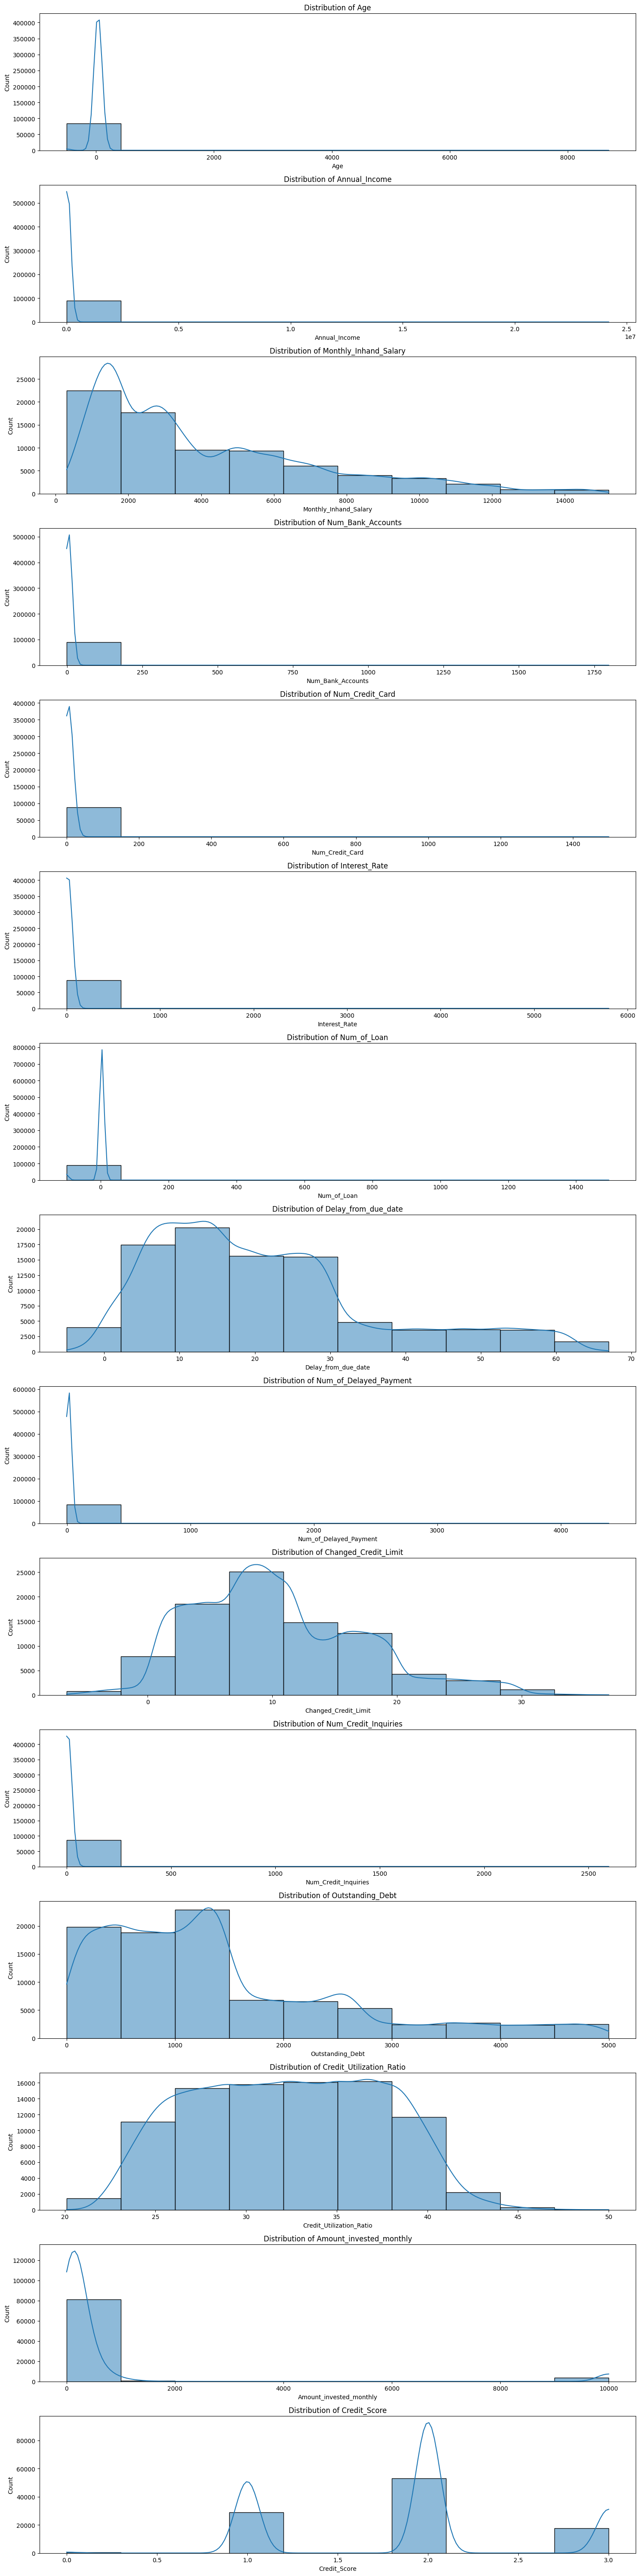

In [13]:
# Loop through all numerical columns and plot their distributions : it does not work yet!!!!!
numeric_cols = credit_card_df.select_dtypes(include=['number']).columns

plt.figure(figsize=(15, len(numeric_cols) * 4))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(len(numeric_cols), 1, i)
    sns.histplot(credit_card_df[col], kde=True, bins=10)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

In [14]:
# numeric_cols = credit_card_df.select_dtypes(include=['number']).columns

# # Create a grid layout for better visualization
# n_cols = 3  # Number of columns in the grid
# n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  # Calculate required number of rows

# # Create subplots with a grid layout
# fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
# axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# # Loop through all numerical columns and plot their distributions
# for i, col in enumerate(numeric_cols):
#     # Determine appropriate number of bins based on data characteristics
#     if credit_card_df[col].nunique() < 10:
#         bins = credit_card_df[col].nunique()  # Discrete data with few values
#     else:
#         bins = 'auto'  # Let Seaborn determine optimal bins
    
#     # Create histogram with kernel density estimate
#     sns.histplot(data=credit_card_df, x=col, kde=True, bins=bins, ax=axes[i])
    
#     # Add mean and median lines for reference
#     mean_val = credit_card_df[col].mean()
#     median_val = credit_card_df[col].median()
#     axes[i].axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
#     axes[i].axvline(median_val, color='green', linestyle='-.', alpha=0.7, label=f'Median: {median_val:.2f}')
    
#     # Add legend and title
#     axes[i].legend(fontsize='small')
#     axes[i].set_title(f'Distribution of {col}')
    
#     # Handle axis labels for better readability
#     if credit_card_df[col].max() > 1000:
#         axes[i].ticklabel_format(style='scientific', axis='x', scilimits=(0,0))

# # Remove any unused subplots
# for j in range(i + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()

Plot the distribution of credit card score respect to a normal distribution to see i there are skewnesses

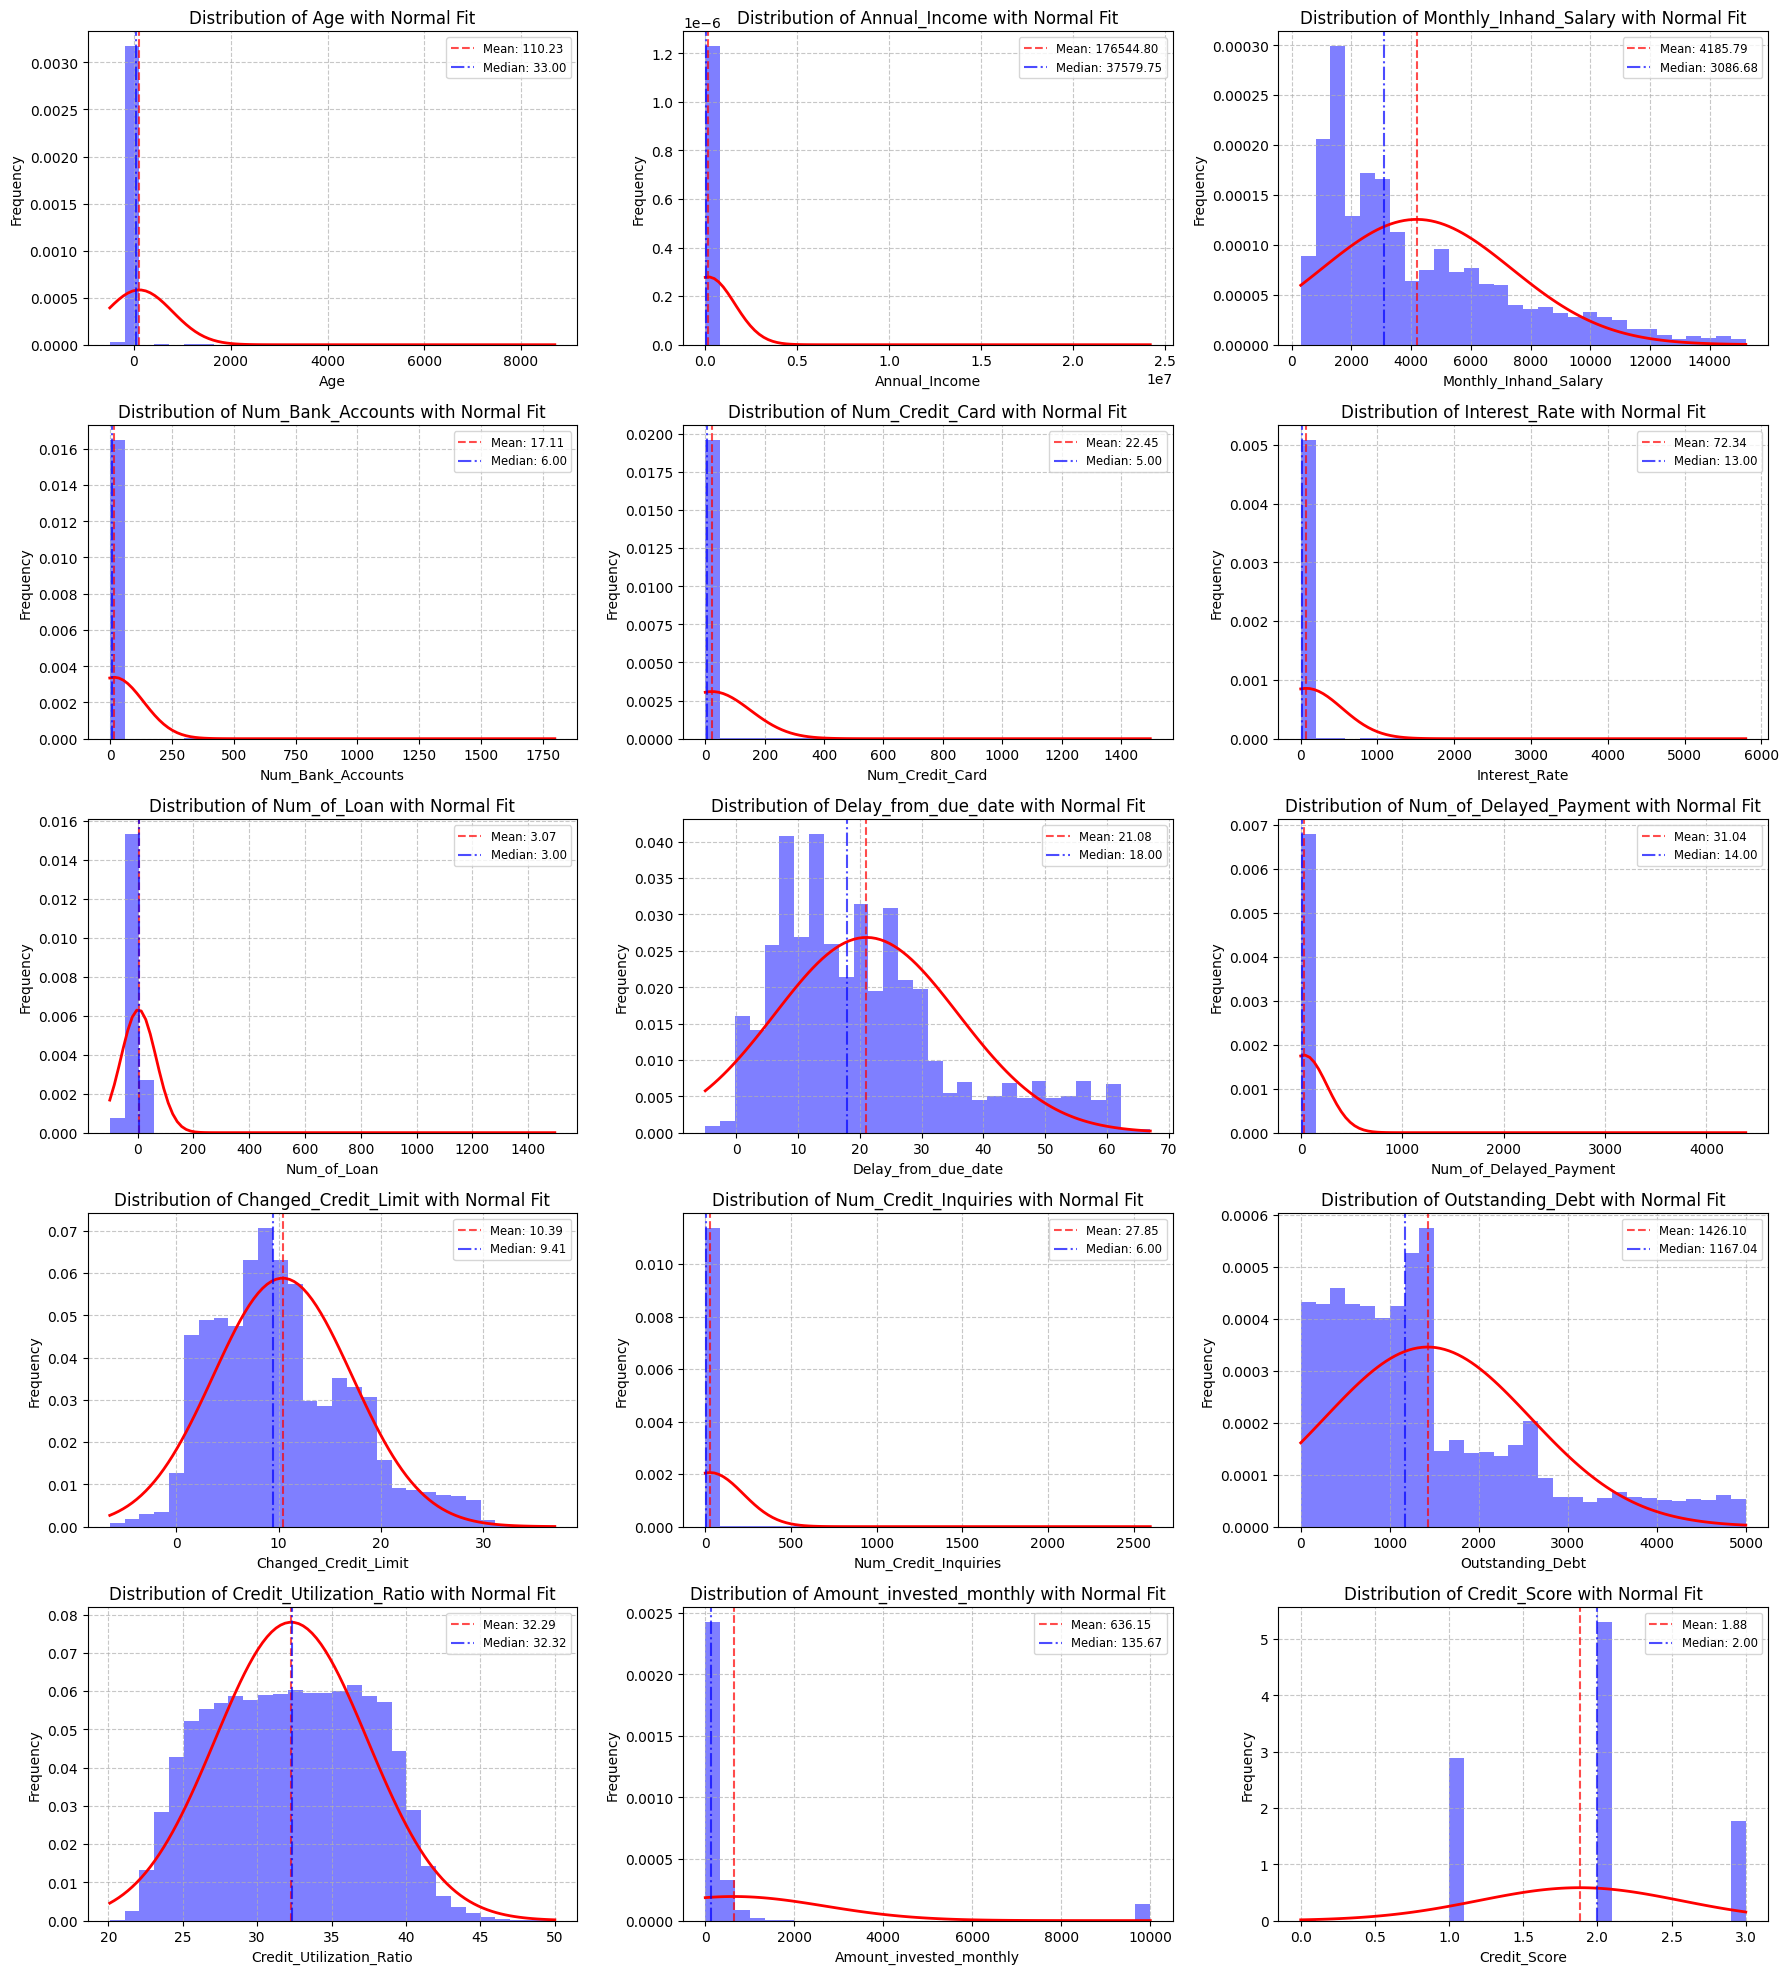

In [15]:
from scipy.stats import norm


# Get the list of numerical feature names from the cleaned dataframe.
numeric_features = credit_card_df.select_dtypes(include=['number']).columns
n_features = len(numeric_features)

# Define grid size
n_cols = 3  # Number of columns in the grid
n_rows = (n_features + n_cols - 1) // n_cols  # Calculate required number of rows

# Create subplots with a grid layout
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Loop through all numerical features and plot their distributions
for i, col in enumerate(numeric_features):
    ax = axes[i]
    data = credit_card_df[col].dropna()
    
    # Plot histogram with density normalization
    ax.hist(data, bins=30, density=True, alpha=0.5, color='blue')
    
    # Fit a normal distribution to the data and plot it
    mu, std = norm.fit(data)
    x = np.linspace(data.min(), data.max(), 100)
    y = norm.pdf(x, mu, std)
    ax.plot(x, y, 'r-', lw=2)
    
    # Add vertical lines for mean and median
    mean_val = data.mean()
    median_val = data.median()
    ax.axvline(mean_val, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='blue', linestyle='-.', alpha=0.7, label=f'Median: {median_val:.2f}')
    
    # Add legend, grid, and style ticks
    ax.legend(fontsize='small')
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Set titles and labels
    ax.set_title(f'Distribution of {col} with Normal Fit')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

# Remove any unused subplots if n_features is not a multiple of n_cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Handling Missing Values


### Customer ID

as we have 12500 unique values of Customer_ID over 100k entries it means that many customer are repeated over the entire dataset. So we can iterate over the column Name to fix it 

In [16]:
missing_customerID = credit_card_df['Customer_ID'].isnull().sum()
missing_customerID

9893

In [17]:
# Function to fill missing Customer_ID values based on matching names
def fill_missing_customer_id(df):
    """
    Fill missing Customer_ID values using the most common ID for each name.
    
    Parameters:
        df: The input DataFrame with Name and Customer_ID columns
    
    Returns:
        DataFrame with missing Customer_ID values filled
    """
    # Count missing values before
    missing_before = df['Customer_ID'].isnull().sum()
    print(f"Missing Customer_ID values before: {missing_before}")
    
    # Check if there are any missing values to fill
    if missing_before == 0:
        print("No missing Customer_ID values to fill.")
        return df
    
    # Create a copy to avoid modifying the original during calculation
    result_df = df.copy()
    
    # Only use rows that have both a Name and a valid Customer_ID to compute the mode
    valid = df.dropna(subset=['Name', 'Customer_ID'])
    
    # Find the most common Customer_ID for each Name
    mode_mapping = valid.groupby('Name')['Customer_ID'].agg(lambda x: x.mode().iloc[0] if not x.empty else None)
    
    # Create a mask for rows with missing Customer_ID
    missing_mask = result_df['Customer_ID'].isnull()
    
    # Apply the mapping in one vectorized operation
    result_df.loc[missing_mask, 'Customer_ID'] = result_df.loc[missing_mask, 'Name'].map(mode_mapping)
    
    # Count missing values after filling
    missing_after = result_df['Customer_ID'].isnull().sum()
    print(f"Missing Customer_ID values after: {missing_after}")
    print(f"Fixed {missing_before - missing_after} values ({(missing_before - missing_after)/missing_before:.2%} of missing values)")
    
    # Check if any values couldn't be filled
    if missing_after > 0:
        print(f"Warning: Could not fill {missing_after} Customer_ID values because their Names don't match any known Customer_ID")
    
    return result_df

# Apply the function to fix missing Customer_ID values
credit_card_df = fill_missing_customer_id(credit_card_df)

Missing Customer_ID values before: 9893
Missing Customer_ID values after: 1891
Fixed 8002 values (80.89% of missing values)


In [18]:
# check if how many rows are missing both Customer_ID and Name and tell me their index
missing_rows = credit_card_df[credit_card_df['Customer_ID'].isnull() & credit_card_df['Name'].isnull()]
missing_rows_indices = missing_rows.index.tolist()
print(f"Indices of rows with missing Customer_ID and Name: {missing_rows_indices}")

Indices of rows with missing Customer_ID and Name: [108, 109, 216, 241, 311, 367, 489, 539, 587, 668, 693, 704, 747, 765, 837, 865, 875, 1127, 1229, 1320, 1344, 1421, 1433, 1518, 1530, 1556, 1753, 1786, 1817, 1837, 1842, 1873, 1882, 1907, 1967, 1977, 1984, 2007, 2022, 2030, 2209, 2247, 2434, 2445, 2500, 2526, 2537, 2551, 2678, 2727, 2834, 2886, 2917, 3048, 3101, 3148, 3157, 3279, 3284, 3382, 3555, 3571, 3629, 3664, 3717, 3769, 3784, 3816, 3823, 3913, 3980, 4151, 4200, 4220, 4223, 4231, 4317, 4398, 4399, 4790, 4820, 4833, 4854, 4937, 4946, 4949, 5046, 5069, 5122, 5131, 5154, 5176, 5186, 5203, 5283, 5426, 5462, 5534, 5554, 5585, 5613, 5672, 5687, 5785, 5811, 5856, 5957, 5983, 6038, 6074, 6087, 6156, 6287, 6310, 6358, 6388, 6578, 6622, 6750, 6877, 6883, 7098, 7101, 7104, 7203, 7209, 7227, 7318, 7338, 7510, 7569, 7761, 7784, 7804, 7849, 7853, 7945, 7958, 7960, 7969, 8035, 8072, 8175, 8283, 8306, 8488, 8588, 8630, 8715, 8731, 8737, 8755, 8870, 8988, 9012, 9023, 9074, 9098, 9150, 9172, 9301,

#### Theory of subsequential dataset

We found out that each client has a monthly analysis of his credit cards on a range of months that goes from january to august. Here we want to prove that we can fix the remaining missing values for customer ID going in one of the other lines that are i range of january august and fix it. 

In [19]:
# Calculate the number of rows per customer
rows_per_customer = credit_card_df.groupby('Customer_ID').size()
print("Average entries per customer:", rows_per_customer.mean())


Average entries per customer: 7.84872


with this I proved that for each customer we have an average of 8 rows (this is pretty accurate because we have only 1891 missing customer IDs over 100k entries). As the lenght of the range of months between January to August is 8 we can proceed by fixing all the remaining missing customer IDs by fixing before the column 'Month'. Before doing this we need to prove that we have a precise number of rows for each client and this is the same for everyone and the clients are in order.

ex. 
| Customer_ID | Month    |
|-------------|----------|
| Client 1    | January  |
| Client 1    | February |
| Client 1    | March    |
| Client 1    | April    |
| Client 1    | May      |
| Client 1    | June     |
| Client 1    | July     |
| Client 1    | August   |

and not something like that

| Customer_ID | Month    |
|-------------|----------|
| Client 1    | January  |
| Client 2    | January  |
| Client 1    | February |
| Client 3    | March    |
| Client 1    | June     |
| Client 5    | April    |

In [20]:
# print me the first 8 rows of the dataset
print(credit_card_df.head(8))

       ID Customer_ID     Month           Name          City         Street  \
0     NaN   CUS_0xd40       NaN  Aaron Maashoh        Lonton  Oxford Street   
1  0x1603   CUS_0xd40  February  Aaron Maashoh        Lonton  Oxford Street   
2  0x1604   CUS_0xd40       NaN            NaN        Lonton  Oxford Street   
3  0x1605   CUS_0xd40     April  Aaron Maashoh        Lonton  Oxford Street   
4     NaN   CUS_0xd40       May  Aaron Maashoh        Lonton  Oxford Street   
5  0x1607   CUS_0xd40      June  Aaron Maashoh        Lonton  Oxford Street   
6  0x1608   CUS_0xd40      July  Aaron Maashoh        Lonton  Oxford Street   
7  0x1609   CUS_0xd40    August            NaN  Standhampton  Oxford Street   

     Age          SSN Occupation  Annual_Income  ...  Num_of_Delayed_Payment  \
0    NaN  821-00-0265    Manager       19114.12  ...                     7.0   
1   23.0  821-00-0265    Manager       19114.12  ...                     NaN   
2 -500.0  821-00-0265    Manager       19114.12 

In [21]:
# print me the last 8 rows of the dataset
print(credit_card_df.tail(8))

            ID Customer_ID     Month   Name          City        Street   Age  \
99992  0x25fe6  CUS_0x942c   January  Nicks      BadShire  North Street  24.0   
99993  0x25fe7  CUS_0x942c  February  Nicks  Standhampton  North Street  25.0   
99994  0x25fe8  CUS_0x942c     March    NaN      BadShire  North Street  25.0   
99995  0x25fe9  CUS_0x942c     April  Nicks      BadShire  North Street   NaN   
99996  0x25fea  CUS_0x942c       May  Nicks      BadShire  North Street  25.0   
99997  0x25feb  CUS_0x942c      June  Nicks      BadShire  North Street  25.0   
99998  0x25fec  CUS_0x942c      July  Nicks  Standhampton  North Street  25.0   
99999  0x25fed  CUS_0x942c    August  Nicks      BadShire  North Street  25.0   

               SSN Occupation  Annual_Income  ...  Num_of_Delayed_Payment  \
99992  078-73-5990    Cleaner       39628.99  ...                     NaN   
99993  078-73-5990    Cleaner       39628.99  ...                     NaN   
99994  078-73-5990    Cleaner       396

$12500 \cdot 8 = 100 000$ which is the exact number of our rows, and as we can see from the previous outputs they're ordered as each client is consequential

In [22]:
# Create a list to store any non-consecutive customer groups
non_consecutive = []

# Group by the combined key (customer_id, SSN)
for (cid, ssn), group in credit_card_df.groupby(['Customer_ID', 'SSN']):
    indices = group.index
    # Calculate the expected length if the block were contiguous
    expected_length = indices.max() - indices.min() + 1
    # Check if the actual group length matches the expected contiguous block length
    if expected_length != len(indices):
        non_consecutive.append((cid, ssn))

if non_consecutive:
    print("The following customer blocks are not contiguous in the current dataset order:")
    for entry in non_consecutive:
        print("Customer_ID:", entry[0], "SSN:", entry[1])
else:
    print("All customers appear as contiguous blocks in the current dataset.")


The following customer blocks are not contiguous in the current dataset order:
Customer_ID: CUS_0x100b SSN: 238-62-0395
Customer_ID: CUS_0x1011 SSN: 793-05-8223
Customer_ID: CUS_0x1013 SSN: 930-49-9615
Customer_ID: CUS_0x1015 SSN: 810-97-7024
Customer_ID: CUS_0x1018 SSN: 731-19-8119
Customer_ID: CUS_0x1032 SSN: 620-58-8045
Customer_ID: CUS_0x1037 SSN: 230-22-9583
Customer_ID: CUS_0x1038 SSN: 355-00-7832
Customer_ID: CUS_0x103e SSN: 155-72-8070
Customer_ID: CUS_0x103e SSN: 795-31-5311
Customer_ID: CUS_0x1044 SSN: 261-18-4430
Customer_ID: CUS_0x1048 SSN: 808-81-2470
Customer_ID: CUS_0x104a SSN: #F%$D@*&8
Customer_ID: CUS_0x104a SSN: 652-58-5852
Customer_ID: CUS_0x104e SSN: 837-93-5062
Customer_ID: CUS_0x1051 SSN: 232-33-7638
Customer_ID: CUS_0x105c SSN: 998-18-7252
Customer_ID: CUS_0x1069 SSN: 761-27-5143
Customer_ID: CUS_0x107c SSN: 712-17-7369
Customer_ID: CUS_0x107e SSN: 463-69-6790
Customer_ID: CUS_0x108a SSN: 394-00-8142
Customer_ID: CUS_0x1098 SSN: 466-10-5742
Customer_ID: CUS_0x10

In [23]:
# Dictionary to hold non-consecutive customer indices
non_consecutive_indices = {}

# Group by the combined key (customer_id, SSN)
for (cid, ssn), group in credit_card_df.groupby(['Customer_ID', 'SSN']):
    indices = group.index.tolist()
    # Calculate the expected contiguous block length based on min and max index
    expected_length = max(indices) - min(indices) + 1
    if expected_length != len(indices):
        non_consecutive_indices[(cid, ssn)] = indices

# Print or return the dictionary of non-consecutive blocks
print("Non-consecutive customer blocks (customer_id, SSN) with their indices:")
for key, inds in non_consecutive_indices.items():
    print("Customer_ID:", key[0], "SSN:", key[1], "Indices:", inds)


Non-consecutive customer blocks (customer_id, SSN) with their indices:
Customer_ID: CUS_0x100b SSN: 238-62-0395 Indices: [1528, 1529, 1531, 1532, 1533]
Customer_ID: CUS_0x1011 SSN: 793-05-8223 Indices: [60120, 60121, 60122, 60124, 60126, 60127]
Customer_ID: CUS_0x1013 SSN: 930-49-9615 Indices: [95216, 95217, 95218, 95220, 95221, 95222]
Customer_ID: CUS_0x1015 SSN: 810-97-7024 Indices: [65208, 65210, 65211, 65212, 65213, 65214, 65215]
Customer_ID: CUS_0x1018 SSN: 731-19-8119 Indices: [82064, 82065, 82066, 82067, 82069, 82070, 82071]
Customer_ID: CUS_0x1032 SSN: 620-58-8045 Indices: [27963, 27965, 27967]
Customer_ID: CUS_0x1037 SSN: 230-22-9583 Indices: [6432, 6433, 6434, 6435, 6436, 6439]
Customer_ID: CUS_0x1038 SSN: 355-00-7832 Indices: [88664, 88665, 88666, 88667, 88669, 88670]
Customer_ID: CUS_0x103e SSN: 155-72-8070 Indices: [34480, 34481, 34482, 34484, 34485, 34486, 34487]
Customer_ID: CUS_0x103e SSN: 795-31-5311 Indices: [67132, 67135]
Customer_ID: CUS_0x1044 SSN: 261-18-4430 Indi

In [24]:
len(non_consecutive_indices)

9155

In [25]:
# print a specific row of the dataset
print(credit_card_df.iloc[60120])

ID                                                                    0x17646
Customer_ID                                                        CUS_0x1011
Month                                                                 January
Name                                                                Schneyerh
City                                                             Standhampton
Street                                                             Old Street
Age                                                                       NaN
SSN                                                               793-05-8223
Occupation                                                         Journalist
Annual_Income                                                        58918.47
Monthly_Inhand_Salary                                               5208.8725
Num_Bank_Accounts                                                         3.0
Num_Credit_Card                                                 

In [26]:
print(credit_card_df.iloc[60121])

ID                                                                    0x17647
Customer_ID                                                        CUS_0x1011
Month                                                                February
Name                                                                Schneyerh
City                                                             Standhampton
Street                                                             Old Street
Age                                                                      44.0
SSN                                                               793-05-8223
Occupation                                                         Journalist
Annual_Income                                                        58918.47
Monthly_Inhand_Salary                                               5208.8725
Num_Bank_Accounts                                                         3.0
Num_Credit_Card                                                 

after I print the first indexes that are assumed to not be consecutive we can clearly see that we're talking about the same customer as they have the same customer and they have subsequent months so we can proceed by fixing the 'Month' column

In [27]:
# Define the expected month order.
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August']

# Reset the index to ensure we're working on the DataFrame's natural order (if needed)
credit_card_df = credit_card_df.reset_index(drop=True)

# Create a new month column with a repeating cycle: each group of 8 rows gets January to August.
credit_card_df['Month'] = [month_order[i % 8] for i in range(len(credit_card_df))]



In [28]:
# Fix Customer ID missing values

# Define the month order and a mapping to positions (0 for January, …, 7 for August).
month_to_index = {month: i for i, month in enumerate(month_order)}

def fill_missing_customer_id(df):
    df = df.copy()
    n_rows = len(df)
    
    # Iterate over each row where Customer_ID is missing.
    for idx, row in df[df['Customer_ID'].isna()].iterrows():
        # Determine the cycle position based on the assigned month.
        # If for some reason month is missing, default to position 0.
        m = row.get('Month', None)
        m_index = month_to_index.get(m, 0)
        
        # Define the search window:
        # Look m rows upward and (7 - m_index) rows downward.
        window_start = max(idx - m_index, 0)
        window_end = min(idx + (7 - m_index), n_rows - 1)
        
        # Extract the window of rows.
        window = df.loc[window_start:window_end, 'Customer_ID']
        # Get all non-missing Customer_ID values in that window.
        non_missing_ids = window.dropna().unique()
        
        if len(non_missing_ids) == 1:
            # If exactly one unique non-missing Customer_ID is found, assign it.
            df.at[idx, 'Customer_ID'] = non_missing_ids[0]
        elif len(non_missing_ids) > 1:
            # If multiple candidate IDs are found, you could choose the first one,
            # or implement more sophisticated logic (e.g. mode, or nearest by distance).
            df.at[idx, 'Customer_ID'] = non_missing_ids[0]
        else:
            # If no candidate is found in the immediate window, you may decide to extend the search.
            # For now, we'll leave it missing.
            pass
    return df

# Example usage:
credit_card_df= fill_missing_customer_id(credit_card_df)


In [29]:
credit_card_df.isnull().sum()

ID                           9942
Customer_ID                     0
Month                           0
Name                        18887
City                         9851
Street                       9920
Age                         14488
SSN                         10001
Occupation                   9944
Annual_Income               10094
Monthly_Inhand_Salary       23595
Num_Bank_Accounts            9833
Num_Credit_Card             10062
Interest_Rate                9849
Num_of_Loan                 10191
Type_of_Loan                20312
Delay_from_due_date          9988
Num_of_Delayed_Payment      16218
Changed_Credit_Limit        11942
Num_Credit_Inquiries        11898
Credit_Mix                   9915
Outstanding_Debt             9963
Credit_Utilization_Ratio     9975
Credit_History_Age          18209
Payment_of_Min_Amount        9957
Amount_invested_monthly     14120
Credit_Score                    0
dtype: int64

### Filling the columns 'Name', 'City', 'Street' and 'Occupation'

For these columns we follow the principle we used before and we scan through the lines which have the same Customer ID to find the missing name city street and occupation that for sure won't change between January and August

In [30]:
cols_invariant = ['Name', 'City', 'Street', 'Occupation']
for col in cols_invariant:
    credit_card_df[col] = credit_card_df.groupby('Customer_ID')[col].transform(lambda x: x.ffill().bfill())



In [31]:
credit_card_df.isnull().sum()

ID                           9942
Customer_ID                     0
Month                           0
Name                            0
City                            0
Street                          0
Age                         14488
SSN                         10001
Occupation                      0
Annual_Income               10094
Monthly_Inhand_Salary       23595
Num_Bank_Accounts            9833
Num_Credit_Card             10062
Interest_Rate                9849
Num_of_Loan                 10191
Type_of_Loan                20312
Delay_from_due_date          9988
Num_of_Delayed_Payment      16218
Changed_Credit_Limit        11942
Num_Credit_Inquiries        11898
Credit_Mix                   9915
Outstanding_Debt             9963
Credit_Utilization_Ratio     9975
Credit_History_Age          18209
Payment_of_Min_Amount        9957
Amount_invested_monthly     14120
Credit_Score                    0
dtype: int64

### Fixing Age

With the age we have two main issues:

1. Some customers between two months have strange values: 
    
        ex. In January they have 23yo and in February -500yo (which is impossible) and in March again 23yo. We'll fix these strange values later but for now is important that we use a normal value so our tempory solution should take in account this
2. Many customers are borned between January and August and so between two months have 1 year more. In this case it's not so important if we have a missing value and for a client we have let's say 4 rows 54 and 4 rows 55 or 3 and 5 rows respectively, so we fill the missing with the mode

In [32]:
def impute_age(ages):
    # Considera come validi solo i valori strettamente maggiori di 0 e minori o uguali a 100
    valid = ages[(ages > 0) & (ages <= 100)].dropna()
    if valid.empty:
        return ages  # Se per un cliente non risultano valori validi, ritorna la serie originale
    # Scegli il valore più frequente (mode); in alternativa, puoi usare valid.median()
    imputed_value = valid.mode().iloc[0]
    # Sostituisci i valori mancanti oppure quelli non validi (<= 0 o > 100) con il valore imputato
    return ages.apply(lambda x: imputed_value if pd.isnull(x) or x <= 0 or x > 100 else x)

# Applica la funzione per imputare 'Age' per ciascun cliente:
credit_card_df['Age'] = credit_card_df.groupby('Customer_ID')['Age'].transform(impute_age)



In [33]:
credit_card_df.isnull().sum()

ID                           9942
Customer_ID                     0
Month                           0
Name                            0
City                            0
Street                          0
Age                             0
SSN                         10001
Occupation                      0
Annual_Income               10094
Monthly_Inhand_Salary       23595
Num_Bank_Accounts            9833
Num_Credit_Card             10062
Interest_Rate                9849
Num_of_Loan                 10191
Type_of_Loan                20312
Delay_from_due_date          9988
Num_of_Delayed_Payment      16218
Changed_Credit_Limit        11942
Num_Credit_Inquiries        11898
Credit_Mix                   9915
Outstanding_Debt             9963
Credit_Utilization_Ratio     9975
Credit_History_Age          18209
Payment_of_Min_Amount        9957
Amount_invested_monthly     14120
Credit_Score                    0
dtype: int64

### Filling Missing SSN Values
We have a column called SSN that represents the Social Security Number, which should uniquely identify a customer. In our dataset, each customer appears in 8 consecutive rows (one per month from January to August). Since a customer's SSN is expected to remain constant over time, any missing or invalid SSN in one row can be reliably filled using a valid SSN from another row belonging to the same customer.

Our approach is as follows:
1. **Clean the SSN values:**  
   We define a function to verify if the SSN matches the standard format (three digits, a dash, two digits, a dash, and four digits). Values that do not meet this pattern or that correspond to known placeholders are set as missing (NaN).

2. **Fill missing values:**  
   By grouping the data using the Customer_ID, we can apply forward fill and backward fill within each group. This ensures that if at least one valid SSN exists among the 8 rows for the same customer, it is propagated to fill any missing values.

This method leverages the consistency of SSN within each customer group and the sequential structure of the dataset.


In [ ]:
import re

# 1) Convertiamo i placeholder speciali in NaN.
def is_valid_ssn(x):
    """
    Verifica se x corrisponde al formato tipico di un SSN: 3 cifre, '-', 2 cifre, '-', 4 cifre.
    Esempio: 821-00-0265
    """
    pattern = r'^\d{3}-\d{2}-\d{4}$'
    return bool(re.match(pattern, str(x)))

def clean_ssn(ssn_value):
    """
    Se ssn_value non rispetta il pattern, restituisce NaN.
    """
    if ssn_value is None:
        return np.nan
    ssn_str = str(ssn_value)
    # Se vogliamo trattare un certo set di stringhe speciali come missing:
    # es: #F%$D@*&8, missing, Missing value, etc.
    placeholders = {"#F%$D@*&8", "Missing value", "_", ""}  # Esempio di placeholders
    if ssn_str in placeholders or not is_valid_ssn(ssn_str):
        return np.nan
    return ssn_str

credit_card_df['SSN'] = credit_card_df['SSN'].apply(clean_ssn)

# 2) Ora raggruppiamo per customer_id e applichiamo ffill + bfill
credit_card_df['SSN'] = credit_card_df.groupby('Customer_ID')['SSN'].transform(lambda x: x.ffill().bfill())

### Checking Column Consistency Across Customer Records
We suspect that some columns (for example, Annual_Income, Monthly_Inhand_Salary, Num_Bank_Accounts, Num_Credit_Card, Interest_Rate, and Num_of_Loan) should remain constant over the 8 monthly records for each customer. However, there is a possibility that for some columns (such as Monthly_Inhand_Salary) the values might change from month to month. 

To decide if we can impute missing values using the same method as before (forward fill and backward fill based on Customer_ID), we first need to verify that the values in these columns do not vary within the same customer. The code below groups the data by Customer_ID and computes the number of unique values for each candidate column obviously excluding the missing values. This allows us to calculate the percentage of customers that have more than one unique value per column.


In [39]:
# Define the candidate columns that might be invariant across months for each customer
candidate_cols = [
    "Annual_Income",
    "Monthly_Inhand_Salary",
    "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Interest_Rate",
    "Num_of_Loan"
]

consistency_results = {}

# Group the dataframe by Customer_ID and calculate the number of unique non-missing values for each column in each group
for col in candidate_cols:
    group_nunique = credit_card_df.groupby("Customer_ID")[col].nunique(dropna=True)  # ignore NaN
    customers_with_variation = (group_nunique > 1).sum()
    total_customers = group_nunique.shape[0]
    proportion_with_variation = customers_with_variation / total_customers
    consistency_results[col] = proportion_with_variation

print("Proportion of customers with variation in each column (ignoring NaNs):")
for column, prop_var in consistency_results.items():
    print(f"{column}: {prop_var:.2%}")


Proportion of customers with variation in each column (ignoring NaNs):
Annual_Income: 15.03%
Monthly_Inhand_Salary: 13.13%
Num_Bank_Accounts: 18.18%
Num_Credit_Card: 23.90%
Interest_Rate: 20.87%
Num_of_Loan: 32.76%


### Filling Missing Values for Columns with Low Variation

Based on the consistency check, some columns (for example, Annual_Income, Monthly_Inhand_Salary, and Num_Bank_Accounts) show variation in only around 15–18% of customers. For these columns, we can assume that they are mostly invariant per customer. Therefore, we can impute missing values by grouping by Customer_ID and using forward fill followed by backward fill to propagate the available value.

For columns that exceed a chosen variation threshold (e.g., more than 20% variation), a different imputation strategy will be necessary, but for now we focus on the ones that appear to be invariant.


In [40]:
# Choose a threshold for variation (here we use 20%)
variation_threshold = 0.20

# Identify columns that are considered invariant (low variation)
invariant_cols = [col for col, prop in consistency_results.items() if prop < variation_threshold]

print("Columns assumed to be invariant:", invariant_cols)

# Impute missing values for these invariant columns using forward fill and backward fill by Customer_ID
for col in invariant_cols:
    # Group by Customer_ID and propagate non-missing values within each group
    credit_card_df[col] = credit_card_df.groupby('Customer_ID')[col].transform(lambda x: x.ffill().bfill())




Columns assumed to be invariant: ['Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts']


### Analysis for columns which have more than 20% 

After analyzing our dataset and examining the distributions of various numeric columns, we noticed that for **Interest_Rate**, **Num_Credit_Card**, and **Num_of_Loan** the distributions (when excluding extreme outliers) are very tight and consistent within each customer. Although we observe some variation, most of it is due to outlier values or data entry errors. Therefore, these columns should ideally be invariant for each customer. 

Based on the distribution analysis and summary statistics, we concluded that imputing missing values with the mode (i.e., the most common valid value) for each customer is the best approach. This method leverages the fact that, apart from a few anomalous outliers, the true value remains constant over time. The code below fills in the missing values for these three columns by grouping the data by `Customer_ID` and replacing missing values with the mode of the group.


In [43]:
# Impute missing values for the selected columns using the mode within each Customer_ID group
columns_to_impute = ["Interest_Rate", "Num_Credit_Card", "Num_of_Loan"]

# For each of these columns, fill missing values with the mode of the values within each customer group
for col in columns_to_impute:
    credit_card_df[col] = credit_card_df.groupby("Customer_ID")[col].transform(lambda x: x.fillna(x.mode().iloc[0] if not x.mode().empty else np.nan))



In [44]:
credit_card_df.isnull().sum()

ID                           9942
Customer_ID                     0
Month                           0
Name                            0
City                            0
Street                          0
Age                             0
SSN                             0
Occupation                      0
Annual_Income                   0
Monthly_Inhand_Salary           0
Num_Bank_Accounts               0
Num_Credit_Card                 0
Interest_Rate                   0
Num_of_Loan                     0
Type_of_Loan                20312
Delay_from_due_date          9988
Num_of_Delayed_Payment      16218
Changed_Credit_Limit        11942
Num_Credit_Inquiries        11898
Credit_Mix                   9915
Outstanding_Debt             9963
Credit_Utilization_Ratio     9975
Credit_History_Age          18209
Payment_of_Min_Amount        9957
Amount_invested_monthly     14120
Credit_Score                    0
dtype: int64